# Compare time-to-convergence vs. batch size
Compare the walltime to get to get from 0.0 train accuracy to 0.60 train accuracy, varying the batch size (8 nodes).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import datetime

/ccs/home/mrowan/.conda/envs/py37/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Plotting preferences

In [2]:
golden = 1.61803398875
figWidth = 5. # inches
figLength = figWidth/golden
figSize1x1 = (figWidth, figLength)

rcParams['font.sans-serif'] = 'Arial'
rcParams['font.family'] = 'sans-serif'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['mathtext.it'] = 'Arial:italic'
rcParams['mathtext.bf'] = 'Arial:bold'
rcParams['axes.labelsize'] = '12'
rcParams['xtick.labelsize'] = '12'
rcParams['ytick.labelsize'] = '12'
rcParams['legend.labelspacing'] = '0.1'
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['ytick.right'] = True
rcParams['xtick.top'] = True
rcParams['axes.linewidth'] = 2.0
rcParams['xtick.major.size'] = 3.5
rcParams['xtick.major.width'] = 1.5
rcParams['xtick.minor.size'] = 2.5
rcParams['xtick.minor.width'] = 1.0
rcParams['ytick.major.size'] = 3.5
rcParams['ytick.major.width'] = 1.5
rcParams['ytick.minor.size'] = 2.5
rcParams['ytick.minor.width'] = 1.0
rcParams['lines.markersize'] = 7
rcParams['lines.linewidth'] = 1.5

markers1 = np.array(['o', '^', 's', 'x', 'd', 'v'])
markers2 = np.array(['s', 'o', 'x', '*'])
# Other options: Dark2, Pastel1, Pastel2, Accent,
# Set1, Set2, Set3, tab10, tab20, tab20b, tab20c
colors = sns.color_palette('muted') + sns.color_palette('dark',)

In [3]:
batch_size = np.array(['32', '128'])
duration_seconds = []

starts = np.array(['18:28:03.263724', '17:01:13.566772']) # 0.0 train_accuracy
stops  = np.array(['19:46:16.130530', '17:39:53.846414']) # >= 0.60 train_accuracy

In [4]:
fmt = '%H:%M:%S.%f'
for i,b in enumerate(batch_size):
    start = datetime.datetime.strptime(starts[i], fmt)
    stop = datetime.datetime.strptime(stops[i], fmt)
    t = stop - start
    t_seconds = t.total_seconds()
    t_minutes = int(round(t.total_seconds() / 60))
    duration_seconds.append(t_seconds)
    print("batch size = {}, duration = {} sec = {} min".format(b, t_seconds, t_minutes))

batch size = 32, duration = 4692.866806 sec = 78 min
batch size = 128, duration = 2320.279642 sec = 39 min


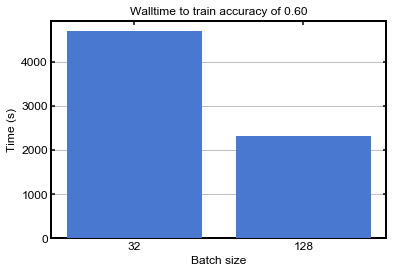

In [6]:
x = range(len(batch_size))
plt.bar(x, duration_seconds, zorder=5, color=colors[0])
plt.xlabel('Batch size')
plt.ylabel('Time (s)')
plt.title('Walltime to train accuracy of 0.60')
plt.gca().yaxis.grid(True)
plt.xticks(x, labels=batch_size);